# Step 03: RAG Agent RAGAS 평가

> Base 모델(qwen3:8b) vs Fine-tuned 모델(qwen3-hr)의 **RAGAS 메트릭** 비교 평가

## 평가 목표

이 노트북은 **RAGAS 4가지 메트릭**으로 RAG Agent를 평가합니다:
- **Faithfulness**: 답변이 검색된 문서 내용만 사용했는가? (환각 방지)
- **Answer Relevancy**: 답변이 질문과 관련있는가?
- **Context Precision**: 검색된 문서가 질문과 관련있는가?
- **Context Recall**: 필요한 정보를 모두 가져왔는가?

## 노트북 구조

```
Part 1: 환경 설정 및 개념 복습
Part 2: 핵심 평가 함수 (RAGAS 패턴)
Part 3: 모델 평가 실행
Part 4: 결과 분석 및 시각화
Part 5: 결과 저장
```

---

## Part 1: 환경 설정 및 개념 복습

### 💡 RAGAS란?

**RAGAS** = **R**etrieval **A**ugmented **G**eneration **A**ssessment **S**ystem

- RAG 시스템의 **"성적표"**를 만들어주는 도구
- 4가지 점수로 RAG 품질을 측정
- **현업 표준** 평가 도구 (논문 기반, 오픈소스)

### RAG vs SQL 평가 비교

| 항목 | RAG | SQL |
|------|-----|-----|
| **평가 대상** | 텍스트 답변 | 쿼리 실행 결과 |
| **표준 도구** | RAGAS | defog-ai/sql-eval |
| **평가 방식** | LLM-as-Judge | DB 실행 결과 비교 |
| **왜?** | 텍스트는 다양한 표현 | SQL은 결과로 판단 |

### RAGAS 4가지 메트릭

| 메트릭 | 질문 | 낮을 때 개선 방법 |
|--------|------|------------------|
| **Faithfulness** | 문서 내용만 사용했나? | 프롬프트에 "문서만 사용" 강조 |
| **Answer Relevancy** | 질문에 맞는 답변인가? | 프롬프트 개선, 모델 교체 |
| **Context Precision** | 관련 문서를 찾았나? | chunk_size, 임베딩 모델 조정 |
| **Context Recall** | 정보를 다 가져왔나? | top_k 증가, overlap 조정 |

In [1]:
# 1-1. 환경 설정
import os
import sys
import json
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass, asdict
from typing import List, Dict, Any, Optional
import warnings
warnings.filterwarnings('ignore')

# Windows 환경 호환성
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 프로젝트 루트 설정
PROJECT_ROOT = Path.cwd().parent.parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project Root: {PROJECT_ROOT}")

Project Root: C:\workspace\enterprise-hr-agent


In [2]:
# 1-2. 환경 변수 및 모델 설정
from dotenv import load_dotenv
load_dotenv(PROJECT_ROOT / ".env")

# 모델 설정
BASE_MODEL = "qwen3:8b"           # 베이스 모델
FINETUNED_MODEL = "qwen3-hr"      # 파인튜닝 모델
PROVIDER = "ollama"
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")

print(f"Base Model: {BASE_MODEL}")
print(f"Fine-tuned Model: {FINETUNED_MODEL}")
print(f"Ollama URL: {OLLAMA_BASE_URL}")

Base Model: qwen3:8b
Fine-tuned Model: qwen3-hr
Ollama URL: http://localhost:11434


In [3]:
# 1-3. RAGAS 임포트
from ragas import evaluate, EvaluationDataset, SingleTurnSample
from ragas.llms import llm_factory
from langchain_openai import OpenAIEmbeddings
from ragas.metrics._faithfulness import Faithfulness
from ragas.metrics._answer_relevance import AnswerRelevancy
from ragas.metrics._context_precision import ContextPrecision
from ragas.metrics._context_recall import ContextRecall
from ragas.run_config import RunConfig
from openai import OpenAI

print("RAGAS 임포트 완료!")

RAGAS 임포트 완료!


In [4]:
# 1-4. 테스트 데이터 로드
DATA_DIR = PROJECT_ROOT / "data" / "finetuning"

with open(DATA_DIR / "rag_test.json", "r", encoding="utf-8") as f:
    test_cases = json.load(f)

print(f"RAG 테스트 케이스: {len(test_cases)}개")

# 테스트 데이터 미리보기
import pandas as pd
test_df = pd.DataFrame(test_cases)
display(test_df[['id', 'question', 'category']])

RAG 테스트 케이스: 10개


,id,question,category
0,1,병가는 어떻게 사용하나요?,policy_lookup
1,2,육아휴직은 얼마 동안 쓸 수 있어?,policy_lookup
2,3,정직 징계가 뭐야?,term_definition
3,4,재택근무는 어떻게 하는 거야?,policy_lookup
4,5,연장근로 수당은 어떻게 계산해?,calculation
5,6,경조사휴가 종류 알려줘,policy_lookup
6,7,수습기간이 뭐야?,term_definition
7,8,복지포인트는 어디에 쓸 수 있어?,benefit_lookup
8,9,안식휴가는 언제 받을 수 있어?,policy_lookup
9,10,회사 VPN은 뭐야?,term_definition


---

## Part 2: 핵심 평가 함수 (RAGAS 패턴)

### RAGAS 평가 구조

```python
# 1. 평가자 LLM 설정 (gpt-4o-mini - 저렴하고 신뢰성 높음)
evaluator_llm = llm_factory(model="gpt-4o-mini", provider="openai")

# 2. 메트릭 정의
metrics = [Faithfulness(llm=evaluator_llm), ...]

# 3. 평가 샘플 생성
sample = SingleTurnSample(
    user_input="질문",
    retrieved_contexts=["문서1", "문서2"],
    response="생성된 답변",
    reference="정답 (ground_truth)"
)

# 4. 평가 실행
result = evaluate(dataset=eval_dataset, metrics=metrics)
```

In [5]:
# 2-1. 결과 데이터 구조 (dataclass 사용)

@dataclass
class RAGEvalResult:
    """
    단일 테스트 케이스 결과
    
    RAGAS 평가를 위한 결과 구조:
    - question: 사용자 질문
    - answer: LLM 생성 답변
    - contexts: 검색된 문서들
    - ground_truth: 정답
    """
    id: int
    question: str
    category: str
    answer: str
    contexts: List[str]
    ground_truth: str
    success: bool
    error: Optional[str] = None

print("RAGEvalResult 클래스 정의 완료")

RAGEvalResult 클래스 정의 완료


In [6]:
# 2-2. 평가자 LLM 및 메트릭 설정

# OpenAI 클라이언트 설정
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# 평가자 LLM (gpt-4o-mini - 저렴하고 신뢰성 높음)
evaluator_llm = llm_factory(
    model="gpt-4o-mini",
    provider="openai",
    client=openai_client
)

# Embeddings 설정 (AnswerRelevancy에 필요)
evaluator_embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    openai_api_key=os.environ.get("OPENAI_API_KEY")
)

# 4가지 메트릭 정의
metrics = [
    Faithfulness(llm=evaluator_llm),
    AnswerRelevancy(llm=evaluator_llm, embeddings=evaluator_embeddings),
    ContextPrecision(llm=evaluator_llm),
    ContextRecall(llm=evaluator_llm),
]

# RunConfig 설정
run_config = RunConfig(
    max_workers=4,
    timeout=120
)

print("=== RAGAS 평가자 설정 ===")
print(f"평가자 LLM: gpt-4o-mini (OpenAI)")
print(f"Embeddings: text-embedding-3-small")
print(f"RunConfig: max_workers={run_config.max_workers}, timeout={run_config.timeout}s")
print("\n평가 메트릭:")
for m in metrics:
    print(f"  - {m.name}")

=== RAGAS 평가자 설정 ===
평가자 LLM: gpt-4o-mini (OpenAI)
Embeddings: text-embedding-3-small
RunConfig: max_workers=4, timeout=120s

평가 메트릭:
  - faithfulness
  - answer_relevancy
  - context_precision
  - context_recall


In [7]:
# 2-3. 단일 케이스 평가 함수

def evaluate_single_case(
    agent,
    case: Dict
) -> RAGEvalResult:
    """
    단일 테스트 케이스 평가
    
    평가 단계:
    1. RAG Agent로 답변 생성
    2. Retriever로 검색된 문서 가져오기
    3. RAGAS 샘플용 결과 반환
    
    Args:
        agent: RAGAgent 인스턴스
        case: 테스트 케이스 딕셔너리
        
    Returns:
        RAGEvalResult: 평가 결과
    """
    question = case["question"]
    ground_truth = case["ground_truth"]
    
    try:
        # RAG Agent 호출
        response = agent.query(question)
        answer = response["answer"]
        
        # Retriever에서 직접 전체 문서 가져오기 (RAGAS 평가용)
        # response["metadata"]["source_docs"]는 200자로 잘려있어서 부적합
        docs = agent.retriever.invoke(question)
        contexts = [doc.page_content for doc in docs]
        
        return RAGEvalResult(
            id=case["id"],
            question=question,
            category=case["category"],
            answer=answer,
            contexts=contexts,
            ground_truth=ground_truth,
            success=True,
            error=None
        )
        
    except Exception as e:
        return RAGEvalResult(
            id=case["id"],
            question=question,
            category=case["category"],
            answer="",
            contexts=[],
            ground_truth=ground_truth,
            success=False,
            error=str(e)
        )

print("evaluate_single_case 함수 정의 완료")

evaluate_single_case 함수 정의 완료


In [8]:
# 2-4. 모델 전체 평가 함수

def evaluate_model(
    model: str,
    test_cases: List[Dict]
) -> Dict[str, Any]:
    """
    모델 전체 평가 (응답 생성만)
    
    Args:
        model: 모델 이름 (예: "qwen3:8b")
        test_cases: 테스트 케이스 리스트
        
    Returns:
        Dict with model, results, samples
    """
    from core.agents.rag_agent import RAGAgent
    
    print(f"\n{'=' * 50}")
    print(f"모델 평가: {model}")
    print(f"{'=' * 50}")
    
    # RAG Agent 초기화
    agent = RAGAgent(
        model=model,
        provider=PROVIDER,
        base_url=OLLAMA_BASE_URL
    )
    
    results = []
    samples = []
    
    for case in test_cases:
        print(f"  [{case['id']}/{len(test_cases)}] {case['question'][:40]}...")
        result = evaluate_single_case(agent, case)
        results.append(result)
        
        # 성공한 경우에만 RAGAS 샘플 생성
        if result.success:
            sample = SingleTurnSample(
                user_input=result.question,
                retrieved_contexts=result.contexts,
                response=result.answer,
                reference=result.ground_truth
            )
            samples.append(sample)
            print(f"       ✓ 응답 생성 완료")
        else:
            print(f"       ✗ 에러: {result.error[:50]}")
    
    success_count = sum(1 for r in results if r.success)
    print(f"\n응답 생성: {success_count}/{len(results)} 성공")
    
    return {
        "model": model,
        "results": [asdict(r) for r in results],
        "samples": samples,
        "success_count": success_count
    }

print("evaluate_model 함수 정의 완료")

evaluate_model 함수 정의 완료


In [9]:
# 2-5. RAGAS 점수 추출 유틸리티

def get_score(result, metric_name):
    """결과에서 점수 추출 (리스트면 평균 계산)"""
    value = result[metric_name]
    if isinstance(value, list):
        valid = [v for v in value if v is not None and v == v]  # NaN 제외
        return sum(valid) / len(valid) if valid else 0.0
    return value

def get_scores_list(result, metric_name):
    """결과에서 개별 점수 리스트 추출"""
    value = result[metric_name]
    if isinstance(value, list):
        return value
    return [value]

print("점수 추출 유틸리티 정의 완료")

점수 추출 유틸리티 정의 완료


---

## Part 3: 모델 평가 실행

### 평가 프로세스

1. **응답 생성**: RAG Agent로 각 테스트 케이스 응답 생성
2. **RAGAS 평가**: gpt-4o-mini로 4가지 메트릭 평가
3. **결과 비교**: Base vs Fine-tuned 모델 비교

In [10]:
%%time
# 3-1. Base 모델 응답 생성
print("🔵 Base 모델 응답 생성 시작")
base_eval = evaluate_model(BASE_MODEL, test_cases)

🔵 Base 모델 응답 생성 시작

모델 평가: qwen3:8b
  [1/10] 병가는 어떻게 사용하나요?...
       ✓ 응답 생성 완료
  [2/10] 육아휴직은 얼마 동안 쓸 수 있어?...
       ✓ 응답 생성 완료
  [3/10] 정직 징계가 뭐야?...
       ✓ 응답 생성 완료
  [4/10] 재택근무는 어떻게 하는 거야?...
       ✓ 응답 생성 완료
  [5/10] 연장근로 수당은 어떻게 계산해?...
       ✓ 응답 생성 완료
  [6/10] 경조사휴가 종류 알려줘...
       ✓ 응답 생성 완료
  [7/10] 수습기간이 뭐야?...
       ✓ 응답 생성 완료
  [8/10] 복지포인트는 어디에 쓸 수 있어?...
       ✓ 응답 생성 완료
  [9/10] 안식휴가는 언제 받을 수 있어?...
       ✓ 응답 생성 완료
  [10/10] 회사 VPN은 뭐야?...
       ✓ 응답 생성 완료

응답 생성: 10/10 성공
CPU times: total: 2.59 s
Wall time: 2min 15s


In [11]:
%%time
# 3-2. Base 모델 RAGAS 평가
print("🔵 Base 모델 RAGAS 평가 시작 (약 5-10분 소요)\n")

base_dataset = EvaluationDataset(samples=base_eval["samples"])
base_ragas_result = evaluate(
    dataset=base_dataset,
    metrics=metrics,
    run_config=run_config
)

print("\nBase 모델 RAGAS 평가 완료!")

🔵 Base 모델 RAGAS 평가 시작 (약 5-10분 소요)



Evaluating: 100%|█████████████████████████████████████████████████████████████████| 40/40 [05:47<00:00,  8.69s/it]



Base 모델 RAGAS 평가 완료!
CPU times: total: 1min 5s
Wall time: 5min 52s


In [12]:
%%time
# 3-3. Fine-tuned 모델 응답 생성
print("🟢 Fine-tuned 모델 응답 생성 시작")
ft_eval = evaluate_model(FINETUNED_MODEL, test_cases)

🟢 Fine-tuned 모델 응답 생성 시작

모델 평가: qwen3-hr
  [1/10] 병가는 어떻게 사용하나요?...
       ✓ 응답 생성 완료
  [2/10] 육아휴직은 얼마 동안 쓸 수 있어?...
       ✓ 응답 생성 완료
  [3/10] 정직 징계가 뭐야?...
       ✓ 응답 생성 완료
  [4/10] 재택근무는 어떻게 하는 거야?...
       ✓ 응답 생성 완료
  [5/10] 연장근로 수당은 어떻게 계산해?...
       ✓ 응답 생성 완료
  [6/10] 경조사휴가 종류 알려줘...
       ✓ 응답 생성 완료
  [7/10] 수습기간이 뭐야?...
       ✓ 응답 생성 완료
  [8/10] 복지포인트는 어디에 쓸 수 있어?...
       ✓ 응답 생성 완료
  [9/10] 안식휴가는 언제 받을 수 있어?...
       ✓ 응답 생성 완료
  [10/10] 회사 VPN은 뭐야?...
       ✓ 응답 생성 완료

응답 생성: 10/10 성공
CPU times: total: 1.08 s
Wall time: 45 s


In [13]:
%%time
# 3-4. Fine-tuned 모델 RAGAS 평가
print("🟢 Fine-tuned 모델 RAGAS 평가 시작 (약 5-10분 소요)\n")

ft_dataset = EvaluationDataset(samples=ft_eval["samples"])
ft_ragas_result = evaluate(
    dataset=ft_dataset,
    metrics=metrics,
    run_config=run_config
)

print("\nFine-tuned 모델 RAGAS 평가 완료!")

🟢 Fine-tuned 모델 RAGAS 평가 시작 (약 5-10분 소요)



Evaluating: 100%|█████████████████████████████████████████████████████████████████| 40/40 [05:43<00:00,  8.59s/it]



Fine-tuned 모델 RAGAS 평가 완료!
CPU times: total: 1min 4s
Wall time: 5min 48s


---

## Part 4: 결과 분석 및 시각화

### 분석 항목
1. **비교 테이블**: Base vs Fine-tuned 4가지 메트릭 비교
2. **막대 그래프**: 시각적 비교
3. **카테고리별 분석**: 질문 유형별 성능
4. **샘플별 상세 분석**: 개별 케이스 점검

In [14]:
# 4-1. 메트릭 계산

base_metrics = {
    "faithfulness": get_score(base_ragas_result, "faithfulness"),
    "answer_relevancy": get_score(base_ragas_result, "answer_relevancy"),
    "context_precision": get_score(base_ragas_result, "context_precision"),
    "context_recall": get_score(base_ragas_result, "context_recall"),
}

ft_metrics = {
    "faithfulness": get_score(ft_ragas_result, "faithfulness"),
    "answer_relevancy": get_score(ft_ragas_result, "answer_relevancy"),
    "context_precision": get_score(ft_ragas_result, "context_precision"),
    "context_recall": get_score(ft_ragas_result, "context_recall"),
}

print("메트릭 계산 완료")

메트릭 계산 완료


In [15]:
# 4-2. 비교 테이블
import pandas as pd

comparison_df = pd.DataFrame({
    "Metric": ["Faithfulness", "Answer Relevancy", "Context Precision", "Context Recall"],
    f"Base ({BASE_MODEL})": [
        f"{base_metrics['faithfulness']:.3f}",
        f"{base_metrics['answer_relevancy']:.3f}",
        f"{base_metrics['context_precision']:.3f}",
        f"{base_metrics['context_recall']:.3f}"
    ],
    f"Fine-tuned ({FINETUNED_MODEL})": [
        f"{ft_metrics['faithfulness']:.3f}",
        f"{ft_metrics['answer_relevancy']:.3f}",
        f"{ft_metrics['context_precision']:.3f}",
        f"{ft_metrics['context_recall']:.3f}"
    ],
    "Δ (차이)": [
        f"{ft_metrics['faithfulness'] - base_metrics['faithfulness']:+.3f}",
        f"{ft_metrics['answer_relevancy'] - base_metrics['answer_relevancy']:+.3f}",
        f"{ft_metrics['context_precision'] - base_metrics['context_precision']:+.3f}",
        f"{ft_metrics['context_recall'] - base_metrics['context_recall']:+.3f}"
    ]
})

print("\n" + "=" * 70)
print("📊 RAGAS 메트릭 비교")
print("=" * 70)
display(comparison_df)


📊 RAGAS 메트릭 비교


,Metric,Base (qwen3:8b),Fine-tuned (qwen3-hr),Δ (차이)
0,Faithfulness,0.878,0.000,-0.878
1,Answer Relevancy,0.246,0.107,-0.139
2,Context Precision,0.776,0.767,-0.008
3,Context Recall,1.000,1.000,+0.000


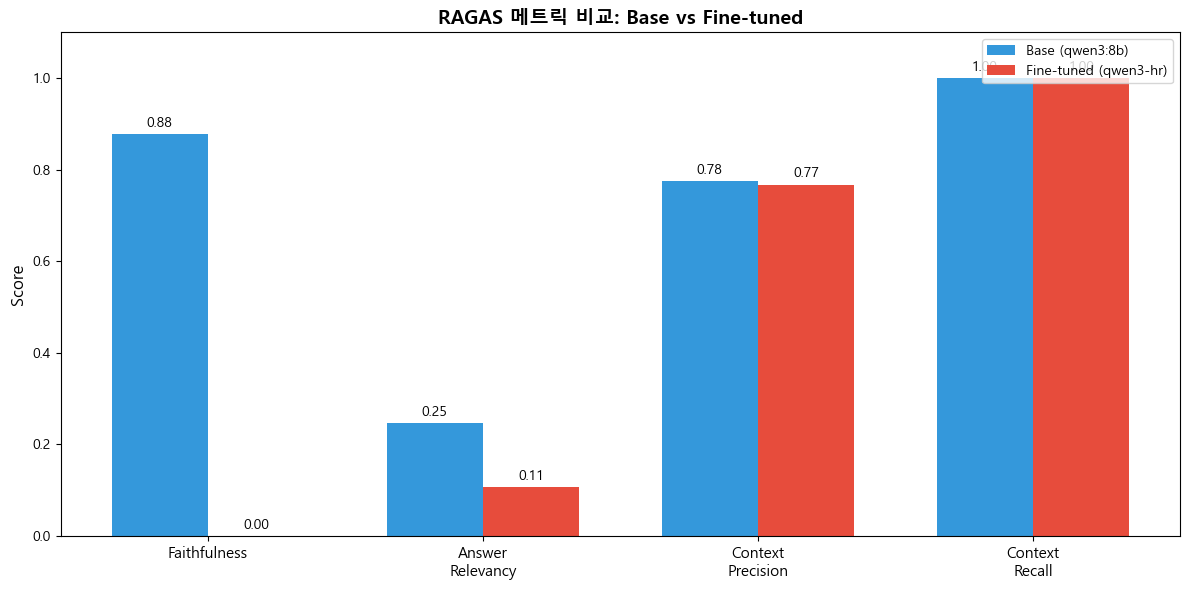

In [16]:
# 4-3. 시각화
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 색상
COLORS = {'base': '#3498db', 'finetuned': '#e74c3c'}

fig, ax = plt.subplots(figsize=(12, 6))

metrics_names = ['Faithfulness', 'Answer\nRelevancy', 'Context\nPrecision', 'Context\nRecall']
metrics_keys = ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall']

x = np.arange(len(metrics_names))
width = 0.35

base_values = [base_metrics[k] for k in metrics_keys]
ft_values = [ft_metrics[k] for k in metrics_keys]

bars1 = ax.bar(x - width/2, base_values, width, label=f'Base ({BASE_MODEL})', color=COLORS['base'])
bars2 = ax.bar(x + width/2, ft_values, width, label=f'Fine-tuned ({FINETUNED_MODEL})', color=COLORS['finetuned'])

ax.set_ylabel('Score', fontsize=12)
ax.set_title('RAGAS 메트릭 비교: Base vs Fine-tuned', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, fontsize=11)
ax.legend(loc='upper right')
ax.set_ylim(0, 1.1)

# 값 표시
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [17]:
# 4-4. 카테고리별 분석

def analyze_by_category(results: List[Dict], ragas_result, model_name: str) -> pd.DataFrame:
    """
    카테고리별 RAGAS 점수 분석
    """
    # 결과를 DataFrame으로
    df = pd.DataFrame(results)
    
    # RAGAS 점수 추가 (성공한 케이스만)
    faithfulness_scores = get_scores_list(ragas_result, "faithfulness")
    relevancy_scores = get_scores_list(ragas_result, "answer_relevancy")
    
    # 성공한 인덱스만 필터링
    success_mask = df['success']
    df_success = df[success_mask].copy()
    
    if len(df_success) == len(faithfulness_scores):
        df_success['faithfulness'] = faithfulness_scores
        df_success['answer_relevancy'] = relevancy_scores
    
    # 카테고리별 평균
    if 'faithfulness' in df_success.columns:
        analysis = df_success.groupby('category').agg({
            'faithfulness': 'mean',
            'answer_relevancy': 'mean'
        }).round(3)
        return analysis
    
    return pd.DataFrame()

print(f"\n📊 카테고리별 RAGAS 점수")
print(f"\n[{BASE_MODEL}]")
base_category = analyze_by_category(base_eval['results'], base_ragas_result, BASE_MODEL)
if not base_category.empty:
    display(base_category)

print(f"\n[{FINETUNED_MODEL}]")
ft_category = analyze_by_category(ft_eval['results'], ft_ragas_result, FINETUNED_MODEL)
if not ft_category.empty:
    display(ft_category)


📊 카테고리별 RAGAS 점수

[qwen3:8b]


,faithfulness,answer_relevancy
category,,
benefit_lookup,1.000,0.195
calculation,1.000,0.184
policy_lookup,0.756,0.187
term_definition,1.000,0.382



[qwen3-hr]


,faithfulness,answer_relevancy
category,,
benefit_lookup,0.0,-0.009
calculation,0.0,0.054
policy_lookup,0.0,0.076
term_definition,0.0,0.215


In [18]:
# 4-5. 샘플별 상세 분석 (첫 3개 샘플)

print("\n" + "=" * 70)
print("📝 샘플별 상세 분석 (상위 3개)")
print("=" * 70)

faithfulness_base = get_scores_list(base_ragas_result, "faithfulness")
faithfulness_ft = get_scores_list(ft_ragas_result, "faithfulness")
relevancy_base = get_scores_list(base_ragas_result, "answer_relevancy")
relevancy_ft = get_scores_list(ft_ragas_result, "answer_relevancy")

for i in range(min(3, len(test_cases))):
    case = test_cases[i]
    print(f"\n[{i+1}] {case['question']}")
    print(f"    카테고리: {case['category']}")
    
    # Base 결과
    if i < len(faithfulness_base):
        f_base = faithfulness_base[i] if faithfulness_base[i] == faithfulness_base[i] else 0
        r_base = relevancy_base[i] if relevancy_base[i] == relevancy_base[i] else 0
        print(f"    Base - Faithfulness: {f_base:.3f}, Relevancy: {r_base:.3f}")
    
    # Fine-tuned 결과
    if i < len(faithfulness_ft):
        f_ft = faithfulness_ft[i] if faithfulness_ft[i] == faithfulness_ft[i] else 0
        r_ft = relevancy_ft[i] if relevancy_ft[i] == relevancy_ft[i] else 0
        print(f"    Fine-tuned - Faithfulness: {f_ft:.3f}, Relevancy: {r_ft:.3f}")


📝 샘플별 상세 분석 (상위 3개)

[1] 병가는 어떻게 사용하나요?
    카테고리: policy_lookup
    Base - Faithfulness: 1.000, Relevancy: 0.162
    Fine-tuned - Faithfulness: 0.000, Relevancy: 0.073

[2] 육아휴직은 얼마 동안 쓸 수 있어?
    카테고리: policy_lookup
    Base - Faithfulness: 1.000, Relevancy: 0.238
    Fine-tuned - Faithfulness: 0.000, Relevancy: 0.130

[3] 정직 징계가 뭐야?
    카테고리: term_definition
    Base - Faithfulness: 1.000, Relevancy: 0.141
    Fine-tuned - Faithfulness: 0.000, Relevancy: 0.023


---

## Part 5: 결과 저장

평가 결과를 JSON 파일로 저장합니다.

In [19]:
# 5-1. 결과 저장

evaluation_results = {
    "timestamp": datetime.now().isoformat(),
    "config": {
        "base_model": BASE_MODEL,
        "finetuned_model": FINETUNED_MODEL,
        "provider": PROVIDER,
        "test_cases_count": len(test_cases),
        "evaluator_llm": "gpt-4o-mini"
    },
    "base": {
        "model": BASE_MODEL,
        "metrics": base_metrics,
        "results": base_eval["results"]
    },
    "finetuned": {
        "model": FINETUNED_MODEL,
        "metrics": ft_metrics,
        "results": ft_eval["results"]
    },
    "comparison": {
        "faithfulness_diff": ft_metrics["faithfulness"] - base_metrics["faithfulness"],
        "answer_relevancy_diff": ft_metrics["answer_relevancy"] - base_metrics["answer_relevancy"],
        "context_precision_diff": ft_metrics["context_precision"] - base_metrics["context_precision"],
        "context_recall_diff": ft_metrics["context_recall"] - base_metrics["context_recall"]
    }
}

output_path = PROJECT_ROOT / "data" / "finetuning" / "rag_evaluation_results.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(evaluation_results, f, ensure_ascii=False, indent=2, default=str)

print(f"✅ 결과 저장됨: {output_path}")

✅ 결과 저장됨: C:\workspace\enterprise-hr-agent\data\finetuning\rag_evaluation_results.json


In [20]:
# 5-2. 최종 요약

print("\n" + "=" * 70)
print("📋 FINAL SUMMARY")
print("=" * 70)

print(f"\n┌{'─'*68}┐")
print(f"│ {'Metric':<25} │ {'Base':>15} │ {'Fine-tuned':>15} │")
print(f"├{'─'*68}┤")
print(f"│ {'Faithfulness':<25} │ {base_metrics['faithfulness']:>15.3f} │ {ft_metrics['faithfulness']:>15.3f} │")
print(f"│ {'Answer Relevancy':<25} │ {base_metrics['answer_relevancy']:>15.3f} │ {ft_metrics['answer_relevancy']:>15.3f} │")
print(f"│ {'Context Precision':<25} │ {base_metrics['context_precision']:>15.3f} │ {ft_metrics['context_precision']:>15.3f} │")
print(f"│ {'Context Recall':<25} │ {base_metrics['context_recall']:>15.3f} │ {ft_metrics['context_recall']:>15.3f} │")
print(f"└{'─'*68}┘")

# 핵심 메트릭 변화
faith_diff = ft_metrics['faithfulness'] - base_metrics['faithfulness']
rel_diff = ft_metrics['answer_relevancy'] - base_metrics['answer_relevancy']

print(f"\n📈 핵심 메트릭 변화:")
print(f"   - Faithfulness: {faith_diff:+.3f} {'📉' if faith_diff < 0 else '📈' if faith_diff > 0 else '='}")
print(f"   - Answer Relevancy: {rel_diff:+.3f} {'📉' if rel_diff < 0 else '📈' if rel_diff > 0 else '='}")


📋 FINAL SUMMARY

┌────────────────────────────────────────────────────────────────────┐
│ Metric                    │            Base │      Fine-tuned │
├────────────────────────────────────────────────────────────────────┤
│ Faithfulness              │           0.878 │           0.000 │
│ Answer Relevancy          │           0.246 │           0.107 │
│ Context Precision         │           0.776 │           0.767 │
│ Context Recall            │           1.000 │           1.000 │
└────────────────────────────────────────────────────────────────────┘

📈 핵심 메트릭 변화:
   - Faithfulness: -0.878 📉
   - Answer Relevancy: -0.139 📉


In [21]:
# 5-3. 권장사항

print("\n" + "=" * 70)
print("💡 권장사항")
print("=" * 70)

if ft_metrics['faithfulness'] < base_metrics['faithfulness'] - 0.1:
    print("""
⚠️ Fine-tuned 모델이 RAG에서 성능이 저하되었습니다!

이는 **Catastrophic Forgetting** 현상입니다:
- SQL 파인튜닝이 일반적인 텍스트 이해 능력을 감소시킴
- Fine-tuned 모델은 SQL 생성에 특화됨

🎯 권장 설정:
┌────────────────────────────────────────────────┐
│  Agent          │  권장 모델                   │
├────────────────────────────────────────────────┤
│  SQL Agent      │  qwen3-hr (Fine-tuned) ✅   │
│  RAG Agent      │  qwen3:8b (Base) ✅         │
└────────────────────────────────────────────────┘

각 Agent에서 모델을 명시적으로 지정하세요:

```python
# SQL Agent - Fine-tuned 모델 사용
sql_agent = SQLAgent(model="qwen3-hr", ...)

# RAG Agent - Base 모델 사용  
rag_agent = RAGAgent(model="qwen3:8b", ...)
```
""")
else:
    print("""
✅ 두 모델의 RAG 성능이 유사합니다.

필요에 따라 선택하세요:
- SQL 쿼리가 중요하면 Fine-tuned 모델
- 일반적인 용도면 Base 모델
""")


💡 권장사항

⚠️ Fine-tuned 모델이 RAG에서 성능이 저하되었습니다!

이는 **Catastrophic Forgetting** 현상입니다:
- SQL 파인튜닝이 일반적인 텍스트 이해 능력을 감소시킴
- Fine-tuned 모델은 SQL 생성에 특화됨

🎯 권장 설정:
┌────────────────────────────────────────────────┐
│  Agent          │  권장 모델                   │
├────────────────────────────────────────────────┤
│  SQL Agent      │  qwen3-hr (Fine-tuned) ✅   │
│  RAG Agent      │  qwen3:8b (Base) ✅         │
└────────────────────────────────────────────────┘

각 Agent에서 모델을 명시적으로 지정하세요:

```python
# SQL Agent - Fine-tuned 모델 사용
sql_agent = SQLAgent(model="qwen3-hr", ...)

# RAG Agent - Base 모델 사용  
rag_agent = RAGAgent(model="qwen3:8b", ...)
```



---

## 평가 완료

이 노트북에서 수행한 내용:

1. ✅ **RAGAS 4가지 메트릭**: Faithfulness, Answer Relevancy, Context Precision, Context Recall
2. ✅ **Base vs Fine-tuned 비교**: 메트릭 테이블 및 시각화
3. ✅ **카테고리별 분석**: 질문 유형별 성능 확인
4. ✅ **결과 저장**: `rag_evaluation_results.json`
5. ✅ **권장사항**: Agent별 최적 모델 제안

### 핵심 발견

SQL 파인튜닝은 **RAG 성능을 저하**시킬 수 있습니다 (Catastrophic Forgetting).

따라서 **각 Agent에 적합한 모델을 사용**하는 것이 최선입니다:
- **SQL Agent**: Fine-tuned 모델 (qwen3-hr)
- **RAG Agent**: Base 모델 (qwen3:8b)